<a href="https://colab.research.google.com/github/dallinmoore/avalanche-forecasting/blob/main/main_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting Avalanche Danger

Project by Dallin Moore

---
## Details
Class: DATA 5610 - Deep Learning

Assignment: Final Project

Prof.: Dr. Sharad Jones

In [ ]:
import requests
import pandas as pd

BASE_URL = "https://wcc.sc.egov.usda.gov/awdbRestApi/services/v1/"

def fetch_snotel_metadata():
    metatdata_url = BASE_URL + "stations"
    params = {
        "stationTriplets": "*:UT:SNTL",
        "returnForecastPointMetadata": "false",
        "returnReservoirMetadata": "false",
        "returnStationElements": "false",
        "activeOnly": "true",
        "durations": "HOURLY"
    }
    response = requests.get(metatdata_url, params=params)
    if response.ok:
        data = response.json()
        return data
    else:
        print("Request failed with status code:", response.status_code)
        return None

keys = ["stationId", "stateCode", "networkCode", "name", "countyName", "elevation", "latitude", "longitude", "beginDate"]
data = fetch_snotel_metadata()
snotel_df = pd.DataFrame([{key: station.get(key, "") for key in keys} for station in data])
snotel_df.head()

,stationId,stateCode,networkCode,name,countyName,elevation,latitude,longitude,beginDate
0,907,UT,SNTL,Agua Canyon,Kane,8890.0,37.52217,-112.27118,1994-10-01 00:00
1,1308,UT,SNTL,Atwater,Salt Lake,8750.0,40.59124,-111.63775,2022-08-25 00:00
2,992,UT,SNTL,Bear River RS,Summit,8510.0,40.88520,-110.82770,2010-10-28 00:00
3,329,UT,SNTL,Beaver Dams,Sanpete,7970.0,39.13683,-111.55813,1980-06-18 00:00
4,330,UT,SNTL,Beaver Divide,Summit,8230.0,40.61233,-111.09782,1978-10-01 00:00


In [ ]:
region_boundaries = {
    "Logan": [
        [41.2, -111.9], [42.0, -111.9],
        [42.0, -111.1], [41.2, -111.1]
    ],
    "Ogden": [
        [40.8, -112.0], [41.2, -112.0],
        [41.2, -111.1], [40.8, -111.1]
    ],
    "Salt Lake": [
        [40.4, -112.0], [40.8, -112.0],
        [40.8, -111.1], [40.4, -111.1]
    ],
    "Uintas": [
        [40.3, -111.1], [41.0, -111.1],
        [41.0, -109.4], [40.3, -109.4]
    ],
    "Provo": [
        [39.8, -112.0], [40.4, -112.0],
        [40.4, -111.1], [39.8, -111.1]
    ],
    "Skyline": [
        [38.9, -111.8], [39.8, -111.8],
        [39.8, -111.1], [38.9, -111.1]
    ],
    "Moab": [
        [38.0, -109.8], [39.0, -109.8],
        [39.0, -108.9], [38.0, -108.9]
    ],
    "Abajos": [
        [37.5, -109.9], [37.9, -109.9],
        [37.9, -109.1], [37.5, -109.1]
    ]
}

SNOTEL stations that are not in the boundaries, but are within 0.4 degrees (roughly 25 miles) are grouped into that region. So some stations are used by multiple regions and some

In [ ]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

# Convert polygon coordinates to shapely Polygon objects
region_shapes = {region: Polygon(coords) for region, coords in region_boundaries.items()}

def determine_region(lat, lon, min_distance_threshold=0.4):
    """Determine which regions a point belongs to based on containment or proximity to boundary."""
    point = Point(lat, lon)
    assigned_regions = []

    # Check each region for containment or proximity to boundary
    for region, polygon in region_shapes.items():
        # Check if point is within the polygon
        if polygon.contains(point):
            assigned_regions.append(region)
        # Check if point is within min_distance_threshold of the polygon's boundary
        else:
            distance = polygon.exterior.distance(point)
            if distance <= min_distance_threshold:
                assigned_regions.append(region)

    return assigned_regions

def map_stations_to_regions(snotel_df):
    """Map SNOTEL stations to regions, allowing multiple region assignments."""
    # Initialize region_stations dictionary
    region_stations = {region: [] for region in region_boundaries.keys()}

    # Map each station to one or more regions
    for _, row in snotel_df.iterrows():
        regions = determine_region(row['latitude'], row['longitude'])
        # Only include stations that are in at least one region
        if regions:
            station_data = {
                'stationId': row['stationId'],  # Include stationId
                'name': row['name'],
                'elevation': row['elevation'],
                'latitude': row['latitude'],
                'longitude': row['longitude']
            }
            # Add the station to all assigned regions
            for region in regions:
                if region in region_stations:  # Ensure region is valid
                    region_stations[region].append(station_data)

    # Print summary
    print("SNOTEL Stations mapped to regions:")
    for region, stations in region_stations.items():
        print(f"{region}: {len(stations)} stations")

    return region_stations

# Run the function
region_stations = map_stations_to_regions(snotel_df)
region_stations['Logan'][:5]

SNOTEL Stations mapped to regions:
Logan: 26 stations
Ogden: 37 stations
Salt Lake: 34 stations
Uintas: 36 stations
Provo: 33 stations
Skyline: 30 stations
Moab: 7 stations
Abajos: 3 stations


[{'stationId': '332',
  'name': 'Ben Lomond Peak',
  'elevation': 7700.0,
  'latitude': 41.37603,
  'longitude': -111.94405},
 {'stationId': '333',
  'name': 'Ben Lomond Trail',
  'elevation': 5980.0,
  'latitude': 41.38291,
  'longitude': -111.92103},
 {'stationId': '374',
  'name': 'Bug Lake',
  'elevation': 7980.0,
  'latitude': 41.68541,
  'longitude': -111.41987},
 {'stationId': '1135',
  'name': 'Burts Miller Ranch',
  'elevation': 7900.0,
  'latitude': 40.98492,
  'longitude': -110.85075},
 {'stationId': '392',
  'name': 'Chalk Creek #1',
  'elevation': 9160.0,
  'latitude': 40.85464,
  'longitude': -111.04765},
 {'stationId': '393',
  'name': 'Chalk Creek #2',
  'elevation': 8200.0,
  'latitude': 40.88529,
  'longitude': -111.06954},
 {'stationId': '455',
  'name': 'Dry Bread Pond',
  'elevation': 8290.0,
  'latitude': 41.41289,
  'longitude': -111.5377},
 {'stationId': '474',
  'name': 'Farmington',
  'elevation': 7920.0,
  'latitude': 40.97462,
  'longitude': -111.80975},
 {'

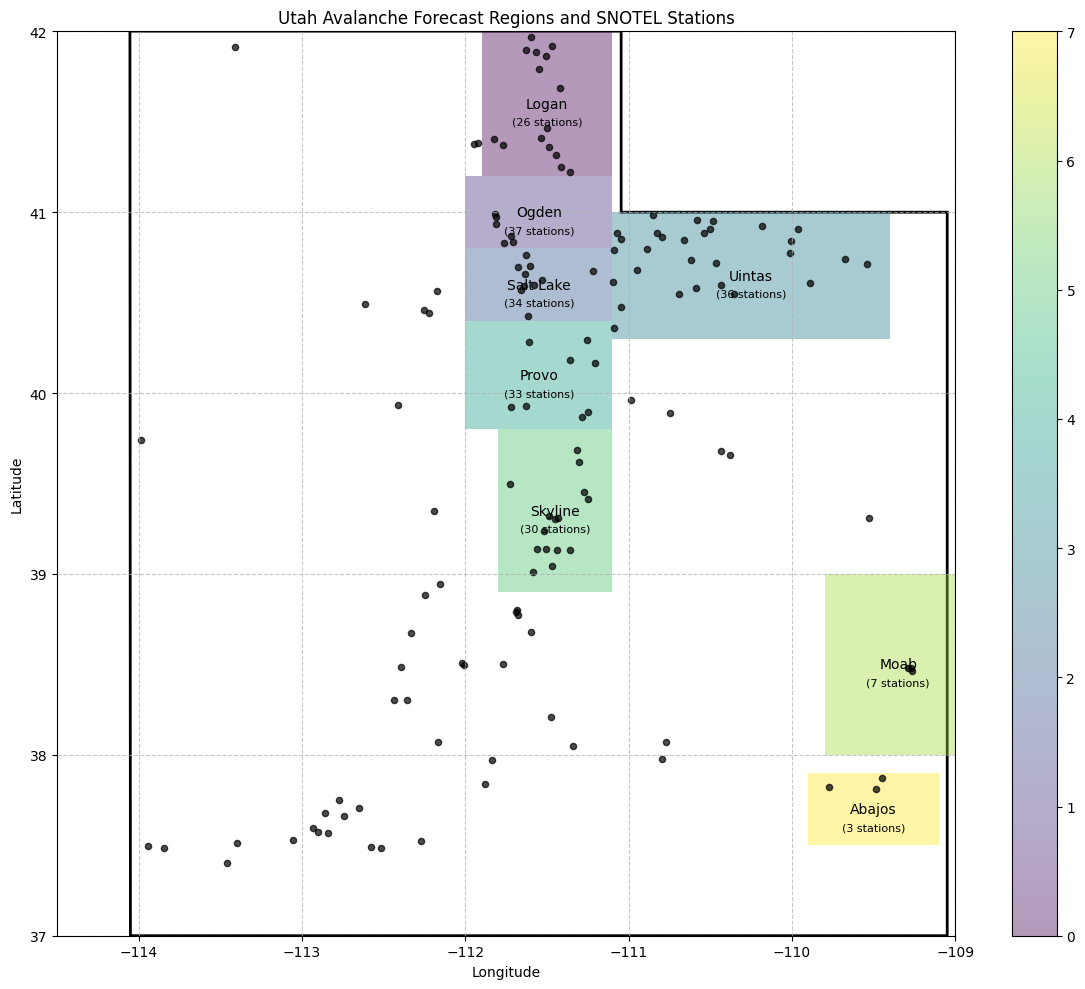

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import matplotlib.colors as mcolors

def visualize_regions(snotel_df, region_stations, region_boundaries):
    # Create a colormap for the regions
    colors = list(mcolors.TABLEAU_COLORS)

    # Prepare figure and axes
    plt.figure(figsize=(12, 10))
    ax = plt.subplot(111)

    # Define Utah state boundary coordinates (approximate, [lat, lon])
    utah_boundary = [
        [42.001, -114.053], [42.001, -111.046], [41.000, -111.046],
        [41.000, -109.050], [37.000, -109.050], [37.000, -114.050],
        [42.001, -114.053]  # Close the polygon
    ]

    # Plot Utah state outline
    utah_coords = np.array(utah_boundary)[:, [1, 0]]  # Swap to [lon, lat]
    utah_polygon = Polygon(utah_coords, closed=True, fill=False, edgecolor='black', linewidth=2)
    ax.add_patch(utah_polygon)

    # Plot region polygons
    patches = []
    region_names = []
    region_centroids = {}

    for i, (region_name, coords) in enumerate(region_boundaries.items()):
        # Convert to numpy array and swap coordinates to [x, y] (lon, lat) for plotting
        coords_array = np.array(coords)[:, [1, 0]]  # Swap lat, lon to lon, lat

        # Create polygon patch
        polygon = Polygon(coords_array, closed=True, fill=True)
        patches.append(polygon)
        region_names.append(region_name)

        # Calculate centroid for label placement
        centroid_x = np.mean([p[1] for p in coords])  # longitude is x
        centroid_y = np.mean([p[0] for p in coords])  # latitude is y
        region_centroids[region_name] = (centroid_x, centroid_y)

    # Create patch collection with specified colormap
    p = PatchCollection(patches, alpha=0.4)
    p.set_array(np.arange(len(patches)))
    ax.add_collection(p)
    plt.colorbar(p)

    # Add region labels at centroids
    for region_name, (x, y) in region_centroids.items():
        ax.text(x, y, region_name, fontsize=10, ha='center', va='center')

    # Plot SNOTEL stations
    ax.scatter(snotel_df['longitude'], snotel_df['latitude'], c='black', s=20, alpha=0.7, label='SNOTEL Stations')

    # Add station count labels
    for region_name, (x, y) in region_centroids.items():
        if region_name in region_stations:
            station_count = len(region_stations[region_name])
            ax.text(x, y - 0.1, f"({station_count} stations)", fontsize=8, ha='center', va='center')

    # Set plot limits
    ax.set_xlim(-114.5, -109.0)
    ax.set_ylim(37.0, 42.0)

    # Add labels and title
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Utah Avalanche Forecast Regions and SNOTEL Stations')
    plt.grid(True, linestyle='--', alpha=0.7)

    # Display the plot
    plt.tight_layout()
    plt.show()

# Run the visualization (assuming snotel_df, region_stations, and region_boundaries are defined)
visualize_regions(snotel_df, region_stations, region_boundaries)

The boundaries are meant to closely match the map used by the [Utah Avalanche Center](https://utahavalanchecenter.org/). Because there are so few stations in the Abajos and Moab region, and their weather patterns differ significantly from the northern 6 regions, they will be ommited.

In [ ]:
regions = ["Logan", "Ogden", "Uintas", "Salt Lake", "Provo", "Skyline"]

In [ ]:
# Dictionary of SNOTEL elements
snotel_elements = {
    "Snow_Depth": "SNWD",
    "SWE": "WTEQ",
    "Snow_Temperature": "SNTMP",
    "Snow_Density": "SS",
    "Air_Temperature": "TA",
    "Precipitation_Increment": "PP",
    "Wind_Speed": "US",
    "Wind_Direction": "UD",
    "Relative_Humidity": "XR",
    "Solar_Radiation_Total": "RW",
    "Soil_Moisture_Percent": "MV",
    "Soil_Temperature": "TV"
}

In [ ]:
from datetime import date, datetime, timedelta


BASE_URL = "https://wcc.sc.egov.usda.gov/awdbRestApi/services/v1/"


def fetch_snotel_data(station_triplet, begin_date, end_date, elements_dict):
    data_url = BASE_URL + "data"
    # Join all element codes for the API request
    elements = ",".join(elements_dict.values())  # e.g., "SNWD,WTEQ,SNTMP,..."
    params = {
        "stationTriplets": station_triplet,
        "beginDate": begin_date,
        "endDate": end_date,
        "elements": elements,
        "duration": "DAILY",
        "centralTendencyType": "AVERAGE"
    }
    response = requests.get(data_url, params=params)
    if response.ok:
        data = response.json()
        return data
    else:
        print(f"Request failed for {station_triplet} with status code: {response.status_code}")
        return None

snotel_data_list = []
for region in regions:
    for station in region_stations[region]:
        station_id = station["stationId"]
        station_triplet = f"{station_id}:UT:SNTL"
        print(f"Fetching data for {station['name']} in {region}...")
        response_data = fetch_snotel_data(station_triplet, "2013-12-13", date.today().strftime("%Y-%m-%d"), snotel_elements)

        if response_data:
            for site_data in response_data:  # This is the outer list of station data
                # Access the data array for this station
                for element_data in site_data.get("data", []):
                    # Get the element code
                    element_code = element_data["stationElement"]["elementCode"]

                    # Process each value in this element's values array
                    for value_item in element_data.get("values", []):
                        # Check if this is the first time we're seeing this date
                        date_str = value_item["date"]

                        # Find or create a new record for this date
                        element_values = next((item for item in snotel_data_list
                                               if item["Date"] == date_str and
                                               item["Station_Name"] == station["name"]), None)

                        if element_values is None:
                            # Create a new record with metadata
                            element_values = {
                                "Date": date_str,
                                "Station_Name": station["name"],
                                "Region": region,
                                "Elevation": station["elevation"],
                                "Latitude": station["latitude"],
                                "Longitude": station["longitude"]
                            }
                            snotel_data_list.append(element_values)

                        # Map this element to its corresponding DataFrame column name
                        for df_name, api_code in snotel_elements.items():
                            if api_code == element_code:
                                element_values[df_name] = value_item.get("value")
                                # If you want to store averages too
                                if "average" in value_item:
                                    element_values[f"{df_name}_avg"] = value_item.get("average")

snotel_df_ts = pd.DataFrame(snotel_data_list)
snotel_df_ts.head()

Fetching data for Ben Lomond Peak in Logan...
Fetching data for Ben Lomond Trail in Logan...
Fetching data for Bug Lake in Logan...
Fetching data for Burts Miller Ranch in Logan...
Fetching data for Chalk Creek #1 in Logan...
Fetching data for Chalk Creek #2 in Logan...
Fetching data for Dry Bread Pond in Logan...
Fetching data for Farmington in Logan...
Fetching data for Farmington Lower in Logan...
Fetching data for Garden City Summit in Logan...
Fetching data for Hardscrabble in Logan...
Fetching data for Horse Ridge in Logan...
Fetching data for Kilfoil Creek in Logan...
Fetching data for Klondike Narrows in Logan...
Fetching data for Lightning Ridge in Logan...
Fetching data for Little Bear in Logan...
Fetching data for Lookout Peak in Logan...
Fetching data for Lost Creek Resv in Logan...
Fetching data for Louis Meadow in Logan...
Fetching data for Monte Cristo in Logan...
Fetching data for Parrish Creek in Logan...
Fetching data for Powder Mountain in Logan...
Fetching data for 

In [ ]:
snotel_df_ts.save("snotel_data_ts.csv")

In [ ]:
forecasts_df = pd.read_csv("avalanche-forecast-rose.csv")
forecasts_df.head()

In [ ]:
import json

with open("region_stations.json", 'w') as file:
    json.dump(region_stations, file, indent=4)